In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filname="../../data/HG002/variants/HG002.GRCh38.2x250_with_mononuc.vcf", samples=["HG002.GRCh38.2x250"])

df_covered_repeats = pd.read_csv("../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.dropna().merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "period", "unit", "ref"]], on="str_id", how="inner"
).reset_index(drop=True)

df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",chr1,588068,588079,3,CCT,4
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 9},"[6, 6]",chr1,589245,589256,2,TC,6
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 60},"[3, 3]",chr1,590659,590670,4,AAAT,3
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 42},"[4, 4]",chr1,590969,590984,4,AAAC,4
4,HG002.GRCh38.2x250,chr1_591734,2,"{18: 2, 20: 9}","[20, 20]",chr1,591734,591751,1,A,18
...,...,...,...,...,...,...,...,...,...,...,...
1677856,HG002.GRCh38.2x250,chrY_26628607,1,{3: 31},[3],chrY,26628607,26628621,5,ATTTT,3
1677857,HG002.GRCh38.2x250,chrY_26632688,1,{6: 9},[6],chrY,26632688,26632705,3,TTC,6
1677858,HG002.GRCh38.2x250,chrY_26635262,1,{10: 33},[10],chrY,26635262,26635271,1,A,10
1677859,HG002.GRCh38.2x250,chrY_26637436,1,{4: 33},[4],chrY,26637436,26637447,3,TTA,4


In [4]:
df_strs_haplotypes = pd.read_csv("../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv").assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [5]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [6]:
df_hg002 = df_hg002.assign(
    illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
)
df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref,illumina_region_len,depth
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",chr1,588068,588079,3,CCT,4,"[12, 12]",22
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 9},"[6, 6]",chr1,589245,589256,2,TC,6,"[12, 12]",9
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 60},"[3, 3]",chr1,590659,590670,4,AAAT,3,"[12, 12]",60
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 42},"[4, 4]",chr1,590969,590984,4,AAAC,4,"[16, 16]",42
4,HG002.GRCh38.2x250,chr1_591734,2,"{18: 2, 20: 9}","[20, 20]",chr1,591734,591751,1,A,18,"[20, 20]",11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677856,HG002.GRCh38.2x250,chrY_26628607,1,{3: 31},[3],chrY,26628607,26628621,5,ATTTT,3,[15],31
1677857,HG002.GRCh38.2x250,chrY_26632688,1,{6: 9},[6],chrY,26632688,26632705,3,TTC,6,[18],9
1677858,HG002.GRCh38.2x250,chrY_26635262,1,{10: 33},[10],chrY,26635262,26635271,1,A,10,[10],33
1677859,HG002.GRCh38.2x250,chrY_26637436,1,{4: 33},[4],chrY,26637436,26637447,3,TTA,4,[12],33


In [7]:
def soft_match(a, b, tolerance = 1):
    """a and b must both be sorted in ascending order"""
    checks = []
    for i, j in zip(a, b):
        checks.append(j - tolerance <= i <= j + tolerance)
    return all(checks)
print(soft_match([13, 14], [14, 14]))
print(soft_match([12, 14], [14, 14]))

True
False


In [8]:
tolerance = 1
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
            softmatch = lambda x: [soft_match(i, j, tolerance) for i, j in zip(x["illumina_region_len"], x["haplo_region_len"])]
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,match,softmatch
0,chr1_588068,"[12, 12]","[12, 12]",True,True
1,chr1_589245,"[12, 12]","[12, 12]",True,True
2,chr1_590659,"[12, 12]","[12, 12]",True,True
3,chr1_590969,"[16, 16]","[16, 16]",True,True
4,chr1_591734,"[20, 20]","[20, 20]",True,True
...,...,...,...,...,...
1677856,chrY_26628607,[15],[15],True,True
1677857,chrY_26632688,[19],[18],False,True
1677858,chrY_26635262,[10],[10],True,True
1677859,chrY_26637436,[12],[12],True,True


In [9]:
print("Overall accuracy:", (1 - (df_comparison.loc[~df_comparison["match"]].shape[0] / df_comparison.shape[0])) * 100)
print("Overall accuracy (softmatch):", (1 - (df_comparison.loc[~df_comparison["softmatch"]].shape[0] / df_comparison.shape[0])) * 100)
df_comparison.loc[~df_comparison["match"]]

Overall accuracy: 94.05832783526168
Overall accuracy (softmatch): 96.93115222297914


,str_id,haplo_region_len,illumina_region_len,match,softmatch
36,chr1_651961,"[16, 16]","[17, 17]",False,True
52,chr1_720655,"[15, 15]","[16, 16]",False,True
53,chr1_725052,"[29, 30]","[29, 29]",False,True
61,chr1_739603,"[10, 10]","[10, 11]",False,True
63,chr1_744867,"[32, 34]","[14, 16]",False,False
...,...,...,...,...,...
1677602,chrY_25109110,[13],[14],False,True
1677621,chrY_26292042,[33],[31],False,False
1677623,chrY_26308422,[17],[16],False,True
1677857,chrY_26632688,[19],[18],False,True


In [31]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 4).reshape(-1, 1), np.tile([1, 10, 10, 20, 20, 30, 30, 1000000], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy_match = []
accuracy_softmatch = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_hg002
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    n.append(df_comparison_filt.shape[0])
    accuracy_match.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)
    accuracy_softmatch.append((1 - (df_comparison_filt.loc[~df_comparison_filt["softmatch"]].shape[0] / df_comparison_filt.shape[0])) * 100)    

df_plot["n"] = n
df_plot["accuracy_match"] = accuracy_match
df_plot["accuracy_softmatch"] = accuracy_softmatch
df_plot["depth"] = np.tile(["1-10", "10-20", "20-30", "30-"], 6)

df_plot

,period,depth_lower,depth_upper,n,accuracy_match,accuracy_softmatch,depth
0,1,1,10,147275,64.014938,82.662366,1-10
1,1,10,20,172711,89.703030,95.344825,10-20
2,1,20,30,270698,98.270028,99.413368,20-30
3,1,30,1000000,272164,99.394850,99.857806,30-
4,2,1,10,4677,43.147317,55.334616,1-10
5,2,10,20,15313,80.284725,84.098478,10-20
6,2,20,30,45057,96.207027,96.704175,20-30
7,2,30,1000000,54683,99.182561,99.327030,30-
8,3,1,10,1843,58.871405,76.234400,1-10
9,3,10,20,6586,86.941998,92.575159,10-20


[None, None]

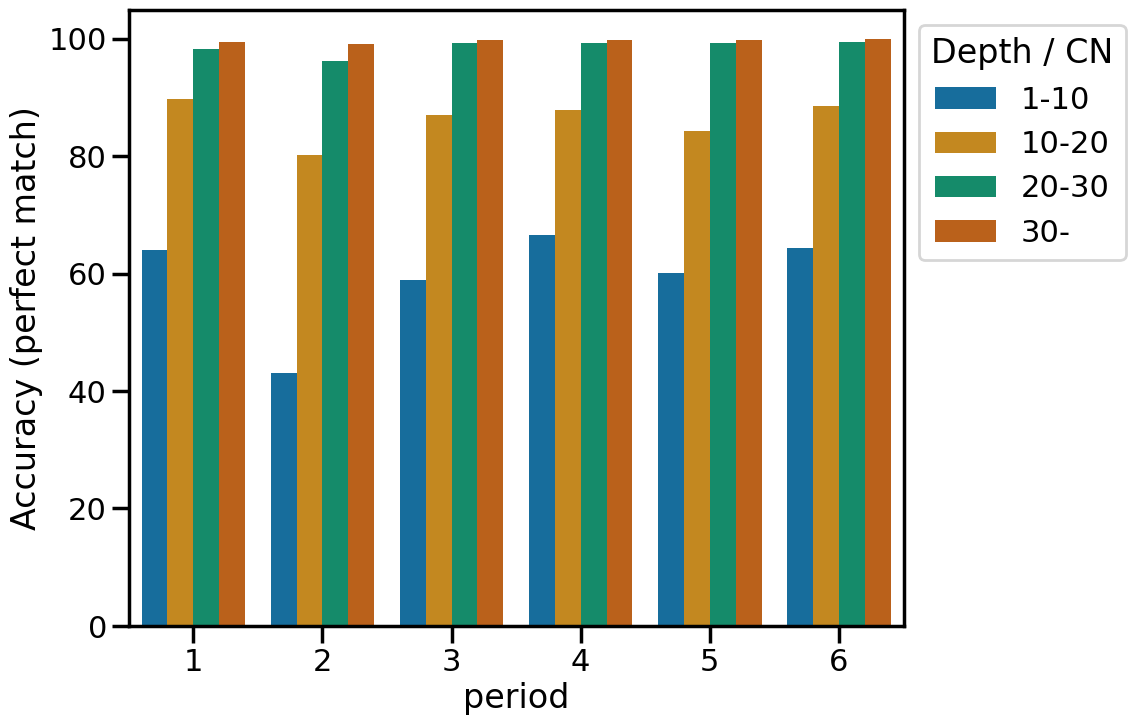

In [11]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy_match",
    hue="depth",
    palette="colorblind"
)

ax.set(
    ylabel = "Accuracy (perfect match)"
)

ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

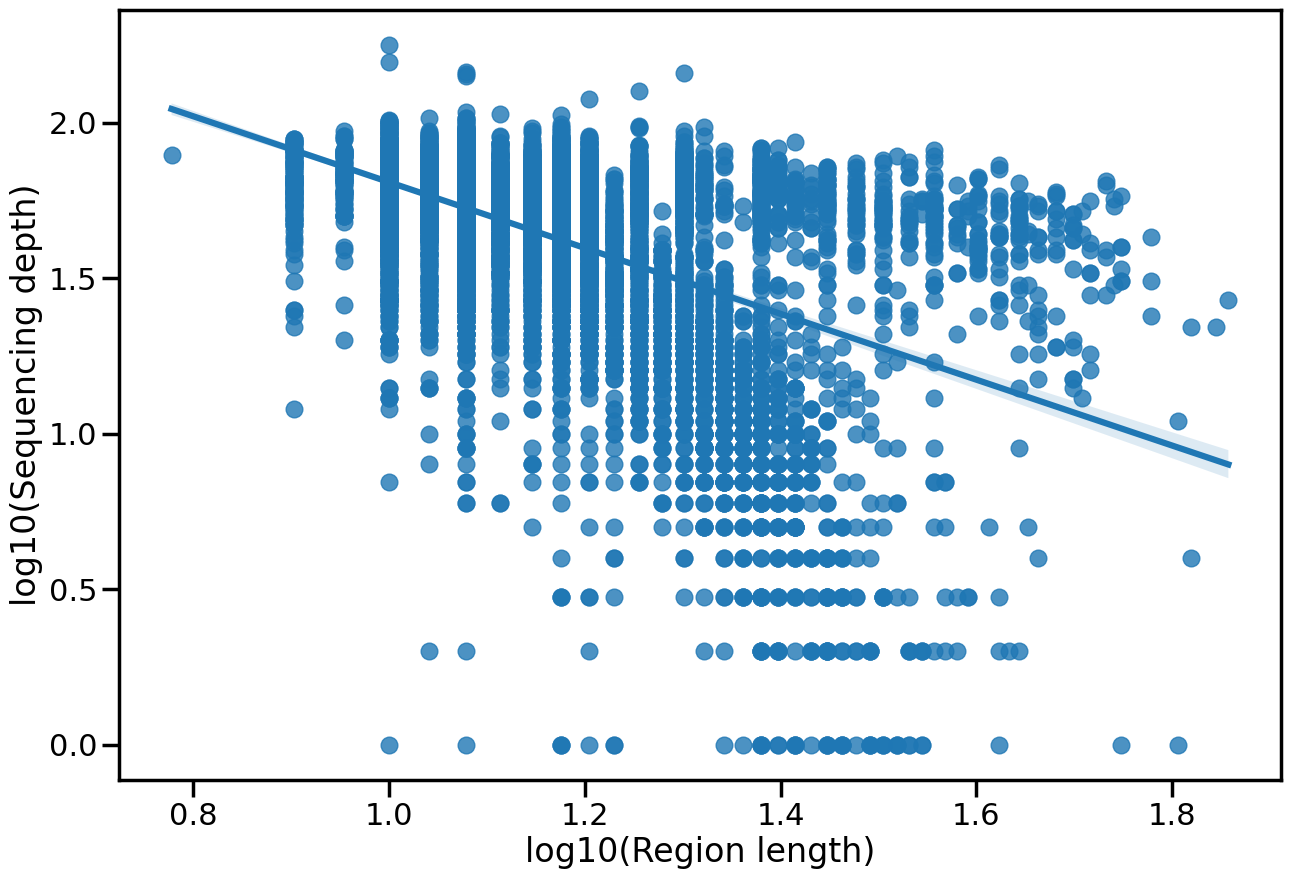

In [12]:
max_depth = 200

fig = plt.figure(figsize=(15, 10))

df_plot = df_hg002.query(f"depth <= {max_depth}")

rng = np.random.default_rng(1)
subset = rng.choice(df_plot.index, 10000, replace=False)

df_plot = df_plot.loc[subset, :]
df_plot

ax = sns.regplot(
    df_plot.assign(
        region_length = lambda x: np.log10(x["ref"] * x["period"]),
        depth = lambda x: np.log10(x["depth"])
    ),
    x="region_length",
    y="depth"
)

ax.set(
    xlabel = "log10(Region length)",
    ylabel = "log10(Sequencing depth)"
)

plt.show()

In [13]:
from scipy import ndimage

max_period = 6
max_depth = 200
min_obs = 15

df_plot_cn = (
    df_comparison
        .merge(df_hg002[["chr", "str_id", "period", "depth", "copy_number"]], on="str_id")        
        .query(f"depth <= {max_depth} and period <= {max_period}")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_cn.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_cn = df_plot_cn.assign(smooth = np.concatenate(smooth))

df_plot_cn

,period,depth,accuracy,n_obs,smooth
0,1,0.5,0.273813,6614,0.401281
1,1,1.0,0.398346,7737,0.413341
2,1,1.5,0.383542,7522,0.435648
3,1,2.0,0.477397,8052,0.465144
4,1,2.5,0.497528,7889,0.498395
...,...,...,...,...,...
964,6,48.0,1.000000,36,0.999853
965,6,48.5,1.000000,34,0.999929
966,6,49.0,1.000000,41,0.999969
967,6,49.5,1.000000,22,0.999988


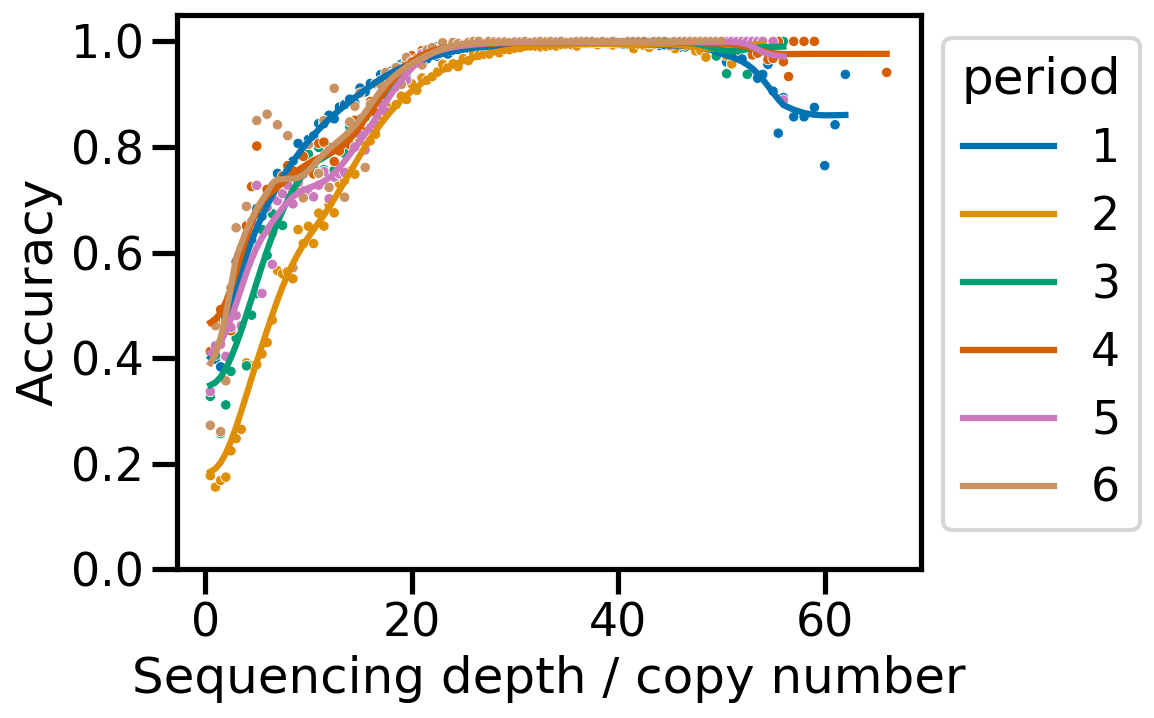

In [14]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_cn,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind",
    # linewidth=2
)

ax = sns.scatterplot(
    df_plot_cn,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    xlabel = "Sequencing depth / copy number",
    ylabel = "Accuracy",
    ylim=(0, 1.05)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

In [28]:
(
    df_hg002
        .query("period == 1 & depth > 100 & depth < 125")
        .sort_values("depth", ascending= False)
        .merge(df_strs_haplotypes[["str_id", "haplo_region_len"]], on="str_id")
        .query("illumina_region_len != haplo_region_len")
        .head(50)
)

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref,illumina_region_len,depth,haplo_region_len
2,HG002.GRCh38.2x250,chr1_248504135,2,"{9: 3, 10: 37, 11: 84}","[10, 11]",chr1,248504135,248504144,1,T,10,"[10, 11]",124,"[9, 10]"
4,HG002.GRCh38.2x250,chr20_29631757,2,"{10: 1, 12: 40, 13: 1, 14: 35, 15: 21, 16: 25}","[12, 14]",chr20,29631757,29631772,1,A,16,"[12, 14]",123,"[15, 16]"
10,HG002.GRCh38.2x250,chr1_148807335,2,"{9: 2, 10: 62, 11: 59}","[10, 11]",chr1,148807335,148807345,1,A,11,"[10, 11]",123,"[10, 15]"
11,HG002.GRCh38.2x250,chr1_174349045,2,"{8: 8, 9: 35, 10: 39, 11: 40}","[10, 11]",chr1,174349045,174349054,1,G,10,"[10, 11]",122,"[9, 10]"
14,HG002.GRCh38.2x250,chr1_248450348,2,"{10: 1, 11: 1, 12: 56, 13: 56, 16: 1, 17: 7}","[12, 13]",chr1,248450348,248450360,1,T,13,"[12, 13]",122,"[13, 13]"
18,HG002.GRCh38.2x250,chr2_91861960,2,"{8: 2, 9: 53, 10: 66, 11: 1}","[9, 10]",chr2,91861960,91861969,1,A,10,"[9, 10]",122,"[10, 10]"
21,HG002.GRCh38.2x250,chr7_38243952,2,"{11: 26, 12: 95}","[12, 12]",chr7,38243952,38243963,1,A,12,"[12, 12]",121,"[11, 12]"
25,HG002.GRCh38.2x250,chr15_82508580,2,"{10: 1, 11: 33, 12: 75, 13: 12}","[11, 12]",chr15,82508580,82508591,1,A,12,"[11, 12]",121,"[12, 12]"
27,HG002.GRCh38.2x250,chr22_21129333,2,"{5: 7, 7: 1, 10: 1, 11: 11, 12: 47, 13: 35, 14...","[12, 13]",chr22,21129333,21129344,1,A,12,"[12, 13]",120,"[11, 15]"
28,HG002.GRCh38.2x250,chr20_29265937,2,"{8: 56, 9: 1, 10: 33, 11: 30}","[8, 10]",chr20,29265937,29265947,1,T,11,"[8, 10]",120,"[10, 11]"


In [15]:
max_period = 6
max_depth = 200
min_obs = 10
df_plot_sex = (
    df_comparison
        .merge(df_hg002[["chr", "str_id", "period", "depth"]], on="str_id")
        .query("chr == 'chrX' or chr == 'chrY'")
        .query(f"depth <= {max_depth} and period <= {max_period}")[["match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_sex.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 2, mode="reflect")
    smooth.append(current_smooth)
df_plot_sex = df_plot_sex.assign(smooth = np.concatenate(smooth))

df_plot_sex

,period,depth,accuracy,n_obs,smooth
0,1,1,0.686856,776,0.804264
1,1,2,0.854671,578,0.824415
2,1,3,0.872283,736,0.855829
3,1,4,0.919084,655,0.887862
4,1,5,0.911967,727,0.914406
...,...,...,...,...,...
451,6,44,1.000000,31,1.000000
452,6,45,1.000000,21,1.000000
453,6,46,1.000000,14,1.000000
454,6,47,1.000000,13,1.000000


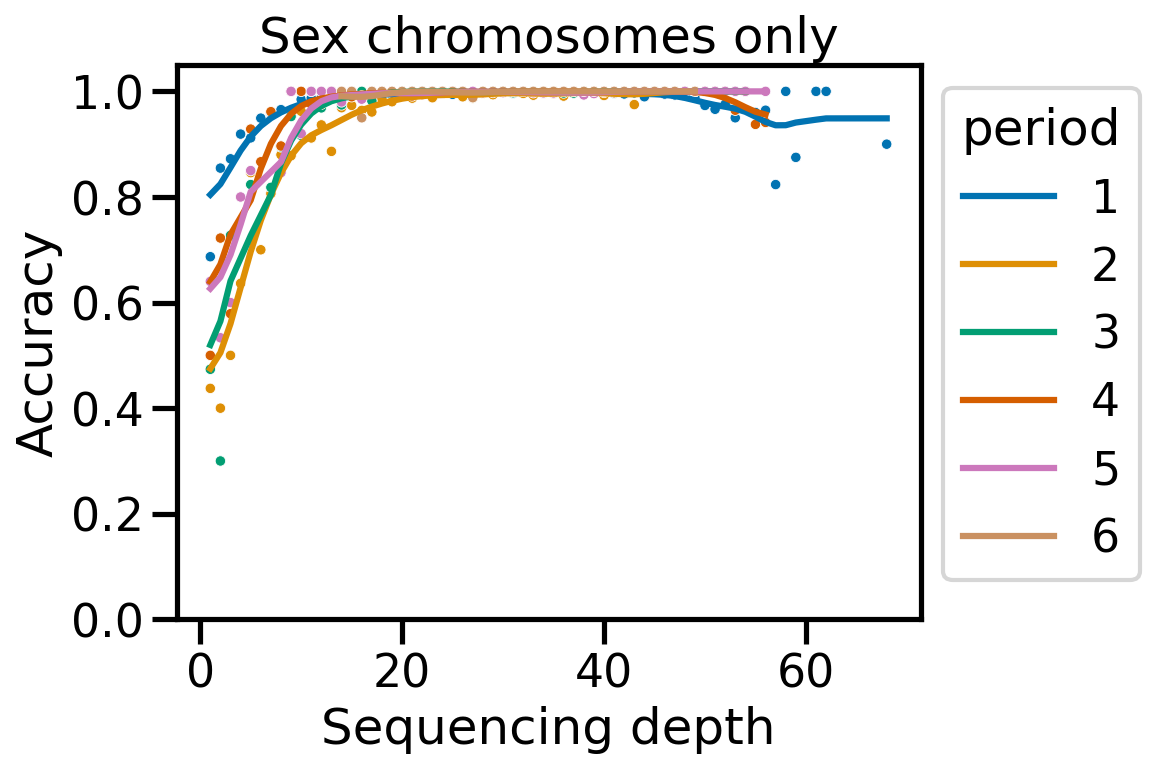

In [16]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_sex,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind"
)

ax = sns.scatterplot(
    df_plot_sex,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title="Sex chromosomes only",
    xlabel = "Sequencing depth",
    ylabel = "Accuracy",
    ylim=(0, 1.05)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

In [17]:
df_plot_auto = (
    df_comparison
        .merge(df_hg002[["chr", "str_id", "period", "depth"]], on="str_id")
        .query("chr != 'chrX' and chr != 'chrY'")
        .query(f"depth <= {max_depth} and period <= {max_period}")[["match", "period", "depth"]]
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_auto.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_auto = df_plot_auto.assign(smooth = np.concatenate(smooth))

df_plot_auto

,period,depth,accuracy,n_obs,smooth
0,1,1,0.273813,6614,0.388156
1,1,2,0.366183,6961,0.400147
2,1,3,0.383542,7522,0.422371
3,1,4,0.448220,7474,0.451847
4,1,5,0.497528,7889,0.485199
...,...,...,...,...,...
926,6,98,1.000000,30,0.999963
927,6,99,1.000000,22,0.999986
928,6,100,1.000000,16,0.999995
929,6,101,1.000000,13,0.999998


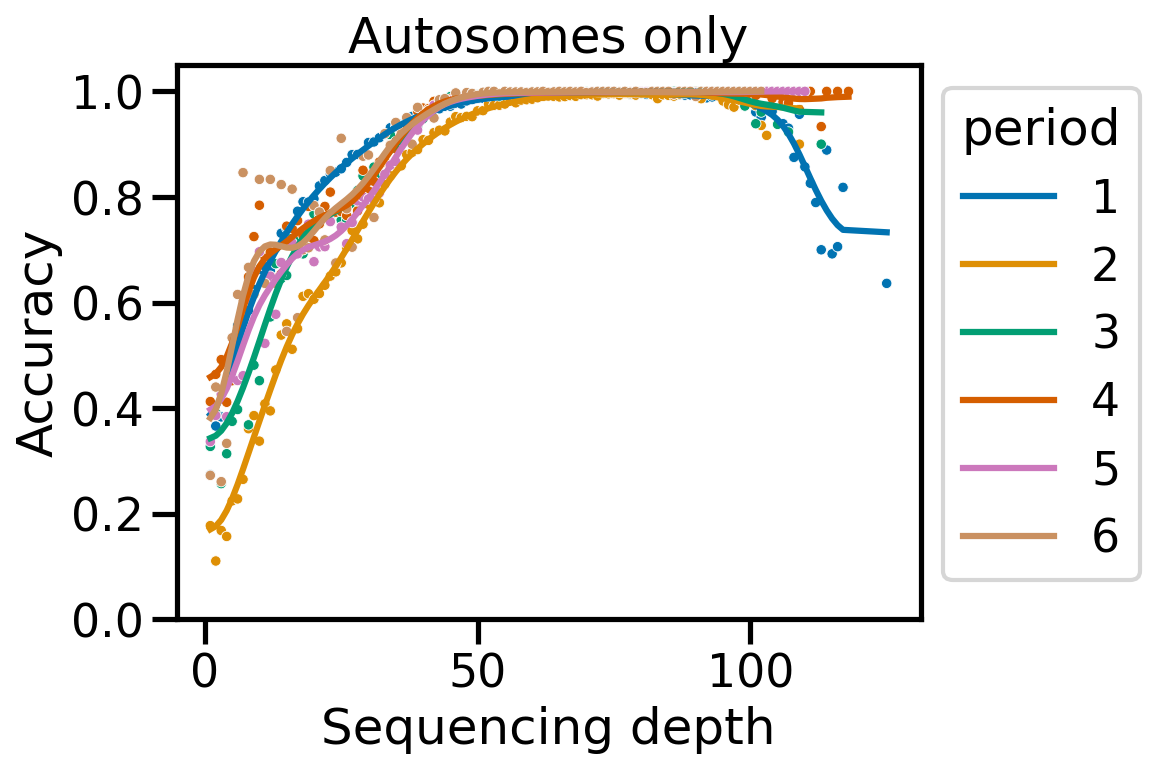

In [18]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_auto,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind"
)

ax = sns.scatterplot(
    df_plot_auto,
    x = "depth",
    y = "accuracy",
    hue = "period",
    palette = "colorblind",
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title="Autosomes only",
    xlabel = "Sequencing depth",
    ylabel = "Accuracy",
    ylim=(0, 1.05)
)

ax.get_legend().set(bbox_to_anchor=(1, 1))

plt.show()

[None, None]

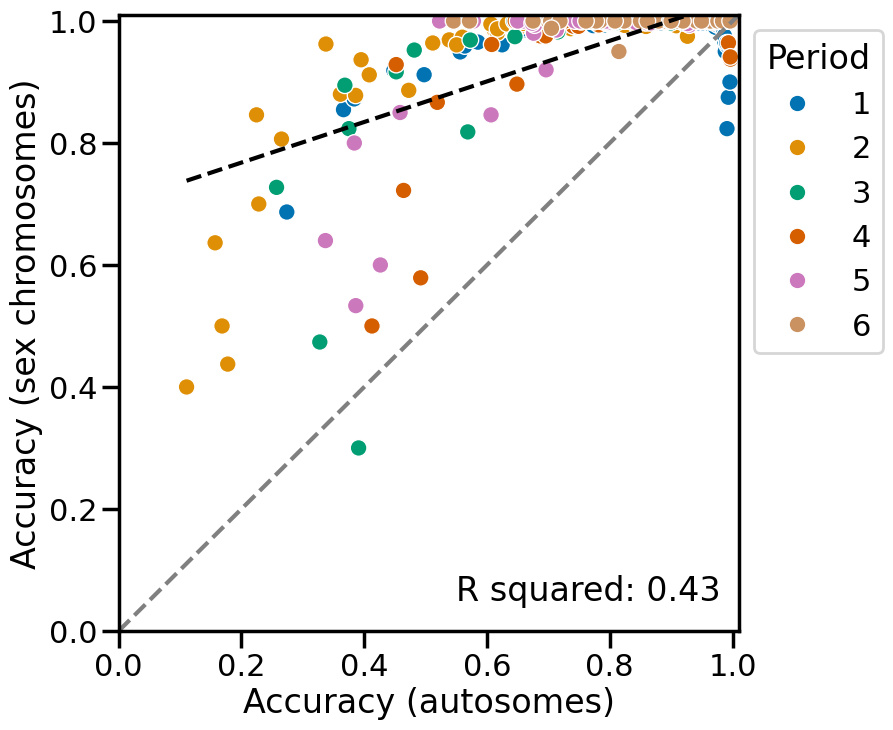

In [19]:
from scipy import stats

df_acc_comparison = df_plot_auto[["period", "depth", "accuracy"]].merge(
        df_plot_sex[["period", "depth", "accuracy"]], 
        on=["period", "depth"], how="inner")

lm = stats.linregress(df_acc_comparison["accuracy_x"], df_acc_comparison["accuracy_y"])

fig = plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    df_acc_comparison,
    x="accuracy_x",
    y="accuracy_y",
    hue="period",
    palette=sns.color_palette("colorblind")[:6]
)

line = np.linspace(0, 1.1, 1000)
sns.lineplot(
    x=line,
    y=line,
    color="grey",
    linestyle="--",
    ax = ax
)

fit = np.linspace(
    df_acc_comparison[["accuracy_x", "accuracy_y"]].min().min(), 
    df_acc_comparison[["accuracy_x", "accuracy_y"]].max().max(), 
    1000
)
sns.lineplot(
    x=fit,
    y=fit * lm.slope + lm.intercept,
    color="black",
    linestyle="--",
    ax = ax
)

ax.set(
    xlim=(0, 1.01),
    ylim=(0, 1.01),
    xlabel="Accuracy (autosomes)",
    ylabel="Accuracy (sex chromosomes)",
)

ax.text(0.55, 0.05, f"R squared: {lm.rvalue**2:.2f}")

ax.get_legend().set(title="Period", bbox_to_anchor=(1,1))

[None, None]

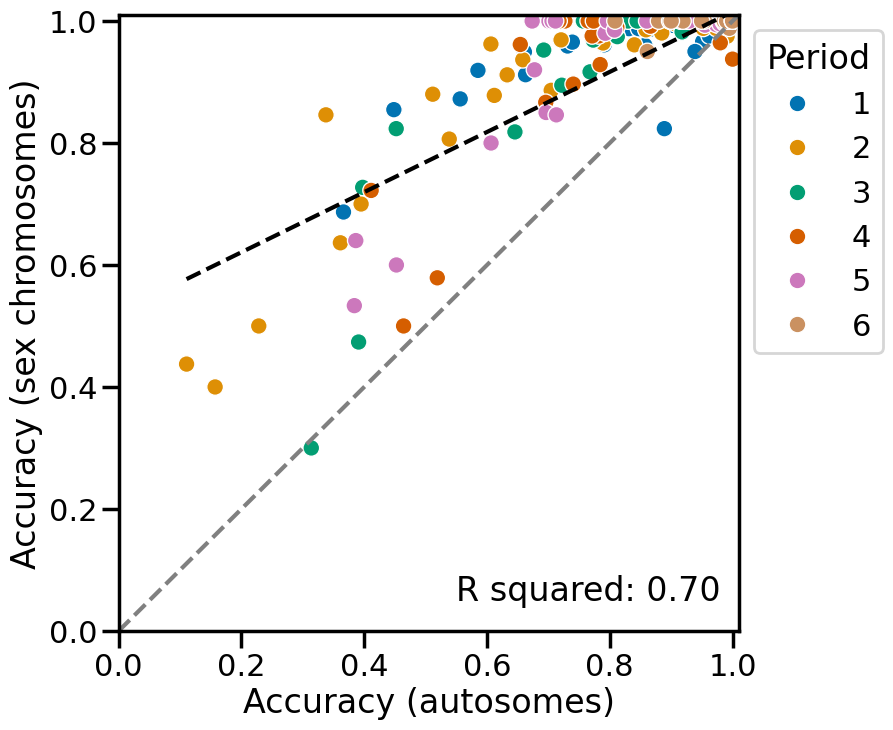

In [20]:
df_acc_comparison_cn = df_plot_auto[["period", "depth", "accuracy"]].merge(
        df_plot_sex[["period", "depth", "accuracy"]].assign(depth = lambda x: x["depth"] * 2), 
        on=["period", "depth"], how="inner")

lm = stats.linregress(df_acc_comparison_cn["accuracy_x"], df_acc_comparison_cn["accuracy_y"])

fig = plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    df_acc_comparison_cn,
    x="accuracy_x",
    y="accuracy_y",
    hue="period",
    palette=sns.color_palette("colorblind")[:6]
)

line = np.linspace(0, 1.1, 1000)
sns.lineplot(
    x=line,
    y=line,
    color="grey",
    linestyle="--",
    ax = ax
)

fit = np.linspace(
    df_acc_comparison_cn[["accuracy_x", "accuracy_y"]].min().min(), 
    df_acc_comparison_cn[["accuracy_x", "accuracy_y"]].max().max(), 
    1000
)
sns.lineplot(
    x=fit,
    y=fit * lm.slope + lm.intercept,
    color="black",
    linestyle="--",
    ax = ax
)

ax.set(
    xlim=(0, 1.01),
    ylim=(0, 1.01),
    xlabel="Accuracy (autosomes)",
    ylabel="Accuracy (sex chromosomes)",
)

ax.text(0.55, 0.05, f"R squared: {lm.rvalue**2:.2f}")

ax.get_legend().set(title="Period", bbox_to_anchor=(1,1))